In [27]:
# import some common libraries
import numpy as np
import warnings
import os, json, cv2, random
from PIL import Image, ImageOps
from os import listdir
from os.path import isfile, join
from tqdm import notebook
import pandas as pd
from shutil import copyfile

In [3]:
mypath="train"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [18]:
def resize_with_padding(img, expected_size, fill):
    img.thumbnail((expected_size[0], expected_size[1]))
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding, fill=fill)

In [19]:
def prep_img(image, save=True):
        img = cv2.imread(f"train/{image}")
        img_rs = resize_img(img)
        if save:
            img_rs.save(f"datatrain2/prep/{image}")
        return img_rs
    
def resize_img(img, size=(1280, 1280), fill=(255, 255, 255)):
    img_rs = to_PIL(img)
    img_rs = resize_with_padding(img_rs, size, fill)
    return img_rs

def to_PIL(img_cv2):
    #print(img_cv2)
    img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img_cv2)

In [21]:
for image in notebook.tqdm(onlyfiles):
    prep_img(image)

  0%|          | 0/9912 [00:00<?, ?it/s]

In [22]:
mypath="datatrain2/prep"
prep = [os.path.splitext(f)[0] for f in listdir(mypath) if isfile(join(mypath, f))]

In [25]:
df = pd.read_csv("train.csv")
df = df[["Id", "Pawpularity"]].set_index("Id").loc[prep]
df["Pawpularity"] = df["Pawpularity"]>=50
df["Pawpularity"].replace({True:1, False:0}, inplace=True)

In [28]:
for index in notebook.tqdm(df[df["Pawpularity"]==1].index):
    copyfile(f"datatrain2/prep/{index}.jpg", f"datatrain2/cute/{index}.jpg")
    
for index in notebook.tqdm(df[df["Pawpularity"]==0].index):
    copyfile(f"datatrain2/prep/{index}.jpg", f"datatrain2/notcute/{index}.jpg")

  0%|          | 0/2119 [00:00<?, ?it/s]

  0%|          | 0/7793 [00:00<?, ?it/s]

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [30]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2155320874586910625
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14474280960
locality {
  bus_id: 1
  links {
  }
}
incarnation: 885274641831207619
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


2021-10-15 08:54:06.339773: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-15 08:54:07.013493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-15 08:54:07.107500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-15 08:54:07.108181: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [36]:
batch_size = 16
img_height = 1280
img_width = 1280
data_dir="datatrain2"

In [40]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9912 files belonging to 2 classes.
Using 7930 files for training.


In [41]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9912 files belonging to 2 classes.
Using 1982 files for validation.


In [42]:
class_names = train_ds.class_names
print(class_names)

['cute', 'notcute']


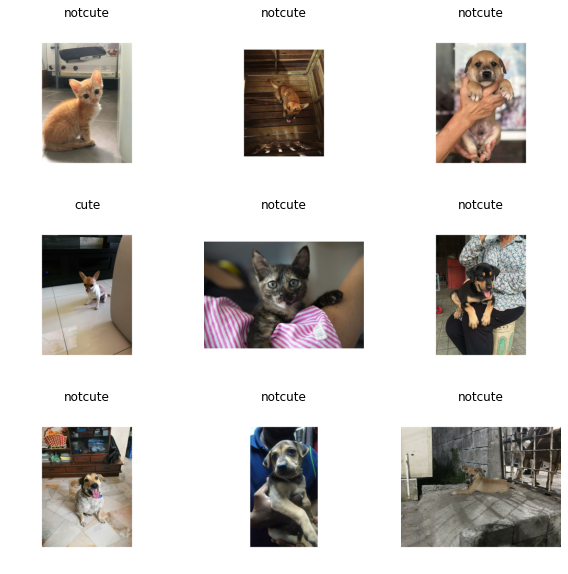

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [44]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [45]:
num_classes = 2
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Flatten(),
  layers.Dense(128, activation='sigmoid'),
  layers.Dense(num_classes)
])

In [50]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001
)

In [51]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [52]:
checkpoint_path = "training/cp2.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
    callbacks=[cp_callback]
)

Epoch 1/15
496/496 [==============================] - 312s 626ms/step - loss: 0.5216 - accuracy: 0.7849 - val_loss: 0.5121 - val_accuracy: 0.7916

Epoch 00001: saving model to training/cp2.ckpt
Epoch 2/15
496/496 [==============================] - 311s 625ms/step - loss: 0.5211 - accuracy: 0.7849 - val_loss: 0.5119 - val_accuracy: 0.7916

Epoch 00002: saving model to training/cp2.ckpt
Epoch 3/15
496/496 [==============================] - 311s 625ms/step - loss: 0.5212 - accuracy: 0.7849 - val_loss: 0.5119 - val_accuracy: 0.7916

Epoch 00003: saving model to training/cp2.ckpt
Epoch 4/15
496/496 [==============================] - 311s 626ms/step - loss: 0.5211 - accuracy: 0.7849 - val_loss: 0.5120 - val_accuracy: 0.7916

Epoch 00004: saving model to training/cp2.ckpt
Epoch 5/15
496/496 [==============================] - 311s 626ms/step - loss: 0.5213 - accuracy: 0.7849 - val_loss: 0.5120 - val_accuracy: 0.7916

Epoch 00005: saving model to training/cp2.ckpt
Epoch 6/15
496/496 [==========